In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyspark as spark
from neo4j import GraphDatabase
from hyperopt import hp

Merged data with black list and got 70 labels down below 

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
panama_and_paradise = pd.read_csv('data/final/leaks.csv')
illegal_entities = ((panama_and_paradise[panama_and_paradise['labels']==1])['entity']).values
#aplply addditional filter where X the degree of the node is small 
#panama_and_paradise= panama_and_paradise[panama_and_paradise['degree']<5]
X = panama_and_paradise[["pagerank","degree_centrality","tax","cpi_score","eigen"]]

X = StandardScaler().fit_transform(X)

#X = panama_and_paradise[panama_and_paradise['degree']<
y=panama_and_paradise['labels']
ones = (y.value_counts().iloc[1])
total = (y.value_counts().iloc[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(panama_and_paradise.shape[0])
((panama_and_paradise[panama_and_paradise['labels']==1])['labels']).value_counts()
print(ones,total)
X_test['']

280553
16901 263652


# Machine learning begins

XG boost model


In [95]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
# generate dataset
model = XGBClassifier(n_estimators = 400,max_depth=9, min_child_weight = 0 ,eta=.4 , scale_pos_weight = total/ones)
model.fit(X_train,y_train)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='average_precision', cv=cv, n_jobs=-1)
# summarize performance
print('Average Precision score: %.5f' % mean(scores))

predictions = model.predict(X_test)


Average Precision score: 0.62583


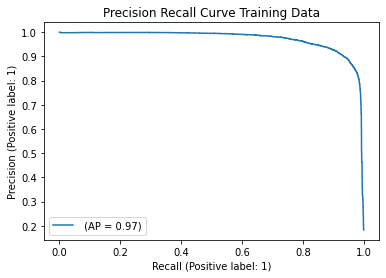

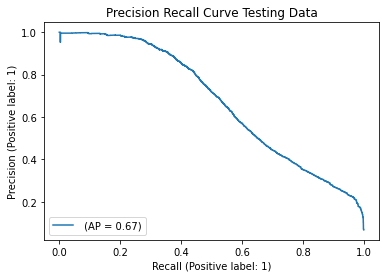

In [96]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, name=""
)
_ = display.ax_.set_title("Precision Recall Curve Training Data")

display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name=""
)
_ = display.ax_.set_title("Precision Recall Curve Testing Data")

In [98]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print(tp/(tp+fn))
print(tp/(tp+fp))


0.7212939921791681
0.4251440544787847


Multilayer perceptron

In [11]:
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from keras.layers import Dense
from keras.models import Sequential
 
# prepare train and test dataset
# def prepare_data():
# 	# generate 2d classification dataset
# 	X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=4)
# 	# split into train and test
# 	n_train = 5000
# 	trainX, testX = X[:n_train, :], X[n_train:, :]
# 	trainy, testy = y[:n_train], y[n_train:]
# 	return trainX, trainy, testX, testy
 
# define the neural network model
def define_model(n_input):
	# define model
	model = Sequential()
	# define first hidden layer and visible layer
	model.add(Dense(10, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
	# define output layer
	model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
	model.compile(loss='binary_crossentropy', optimizer='sgd')
	return model
 
# get the model
n_input = X_train.shape[1]
model = define_model(n_input)
# fit model
weights = {0:1, 1:17}
history = model.fit(X_train, y_train, class_weight=weights, epochs=100, verbose=0)
# evaluate model
yhat = model.predict(X_test)


In [50]:
rclf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

 Random Forest Classifier


In [55]:
rclf = RandomForestClassifier(max_depth=100)
rclf.fit(X_train,y_train)


RandomForestClassifier(max_depth=100)

In [57]:
scores = cross_val_score(rclf, X_test, y_test, scoring='average_precision', cv=cv, n_jobs=-1)
mean(scores)

0.5695480214203524

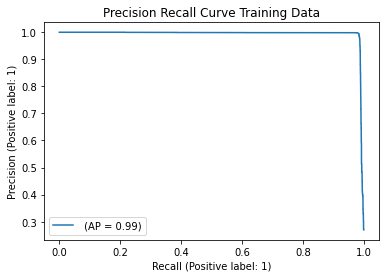

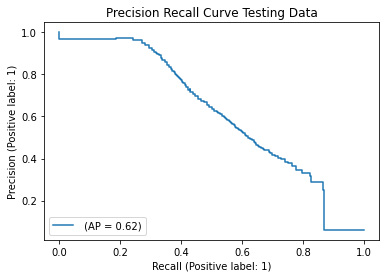

In [77]:
display = PrecisionRecallDisplay.from_estimator(
    rclf, X_train, y_train, name=""
)
_ = display.ax_.set_title("Precision Recall Curve Training Data")

display = PrecisionRecallDisplay.from_estimator(
    rclf, X_test, y_test, name=""
)
_ = display.ax_.set_title("Precision Recall Curve Testing Data")

In [ ]:
# from sklearn.cluster import KMeans

# scores = []
# nclusters = []
# for i in range(1,10):
#     nclusters.append(i)
#     km = KMeans(n_clusters=i,random_state=0).fit(X)
#     scores.append(np.abs(km.score(X)))
# sns.lineplot(x=nclusters,y=scores)

In [ ]:
# km = KMeans(n_clusters=5,random_state=0).fit(X)
# panama_and_paradise['cluster_group']=km.labels_
# panama_and_paradise[panama_and_paradise['labels']==1]
# panama_and_paradise.groupby(['cluster_group']).count()

In [ ]:

pca = PCA(n_components=2)
principleComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principleComponents)
PCA_components['labels'] = panama_and_paradise['labels']
PCA_components['clusters'] = panama_and_paradise['cluster_group']
sns.scatterplot(PCA_components[0], PCA_components[1], alpha=.1, color='black',hue = PCA_components['clusters'])

KeyError: 'cluster_group'

In [ ]:
cypher_query = """MATCH (e:Entity)-[:officer_of]-(o)-[r]-(s:Entity)
WHERE e.name CONTAINS $name AND (s.sourceID STARTS WITH "Paradise Papers" OR s.sourceID STARTS WITH "Panama Papers")
RETURN s.name as entity,s.sourceID as sourceID"""

driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=("neo4j", "password"))
entity_name = []
sourceIDs = []
for entity in illegal_entities:
  with driver.session(database="neo4j") as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query,
                      name=entity).data())
    print(len(results))
    for record in results:
       entity_name.append(record['entity'])
       sourceIDs.append(record['sourceID'])

driver.close()

dfs = pd.DataFrame({'entity':entity_name,'sourceID':sourceIDs})
dfs['sourceID'] = (dfs['sourceID'].str.split(' -')).apply(lambda x: x[0])
dfs = dfs[(dfs['sourceID']=='Paradise Papers') | (dfs['sourceID']=='Panama Papers')]
dfs[dfs['sourceID']=='Paradise Papers']
dfs[dfs['sourceID']=='Panama Papers']
dfs = dfs.drop_duplicates()
dfs

429
244
20
3881
520
3881
255
426
547
472
309
3881
1614
1139
1416
3639
821
1091
326
1538
547
1270
2655
3314
5432
269
1631
1170
3939
400
4171
3847
1065
1215
808
776
194
441
258
3881
7009
1519
722
1151
1041
925
592
380
394
584
318
1151
4113
265
7320
311
5432
3881
3883
988
1292
1015
431
1163
1281
2291
3884
764
3881
124
3901
3884
609
828
2782
274
272
748
817
1051
58
855
1130
9
555
721
416
3881
1956
355
730
2105
2057
683
566
739


StopIteration: 

In [ ]:
sus_entities = dfs['entity'].values
sus_entities
def find_label(value):
    if value in sus_entities:
        return 1 
    else: 
        return 0
panama_and_paradise['labels'] = panama_and_paradise['entity'].apply(find_label)
panama_and_paradise

,Unnamed: 0,entity,pagerank,degree,tax,cpi_score,eigen,degree_centrality,labels
0,0,# 1 APPLIANCES SERVICE AND PARTS,0.245625,0.0,25.0,68.0,0.000215,0.0,0
1,1,# 1 CAR COOLING,0.320000,0.0,25.0,68.0,0.000422,0.0,0
2,2,#1 PAINT STORE,0.277500,0.0,25.0,68.0,0.000215,0.0,0
3,3,#17 GUNSITE INC.,0.277689,0.0,5.5,67.0,0.000422,0.0,0
4,4,$1.00 A DAY RENT-A-CAR LIMITED,0.150564,0.0,0.0,68.0,0.000215,0.0,0
...,...,...,...,...,...,...,...,...,...
280548,280548,winebox limited,0.311500,0.0,35.0,60.0,0.001044,0.0,0
280549,280549,wpd Panama S.A.,0.405000,0.0,25.0,39.0,0.000422,0.0,0
280550,280550,¡2 ASSETS MANAGEMENT LIMITED,0.153984,0.0,33.0,55.0,0.000215,0.0,0
280551,280551,ÑIMI-ÑIMI S.A.,0.430500,0.0,25.0,39.0,0.000630,0.0,0
